In [1]:
import torch
import torchvision.transforms as tvt
from torch.utils.data import DataLoader
from tqdm import tqdm
import shutil
import pandas as pd
import numpy as np
import os
torch.manual_seed(1234)
from evaluate_metrics import compute_eer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Preprocess

In [2]:
# load in the wild protocol
adv2024 = pd.read_csv("protocol_old.txt", sep=" ", header=None)
adv2024.columns = ['utt', 'subset', 'label']
adv2024['sur_model'] = adv2024['utt'].apply(lambda x: x.split('/')[-3])
adv2024['alg'] = adv2024['utt'].apply(lambda x: x.split('/')[-2])
# if alg is 'flac', then change to 'clean'
adv2024['alg'] = adv2024['alg'].apply(lambda x: 'clean' if x == 'flac' else x)
adv2024['sur_model'] = adv2024['sur_model'].apply(lambda x: '-' if x == 'ASVspoof2021_DF_eval' else x)
adv2024.head

<bound method NDFrame.head of                                                      utt subset     label  \
0      Dataset/ASVspoof/LA/ASVspoof2021_DF_eval/flac/...   eval     spoof   
1      Dataset/ASVspoof/LA/ASVspoof2021_DF_eval/flac/...   eval  bonafide   
2      Dataset/ASVspoof/LA/ASVspoof2021_DF_eval/flac/...   eval     spoof   
3      Dataset/ASVspoof/LA/ASVspoof2021_DF_eval/flac/...   eval  bonafide   
4      Dataset/maibui/random_masking_piotrakawa/ASVSp...   eval     spoof   
...                                                  ...    ...       ...   
67846  Dataset/ASVspoof/LA/ASVspoof2021_DF_eval/flac/...   eval     spoof   
67847  Dataset/ASVspoof/LA/ASVspoof2021_DF_eval/flac/...   eval  bonafide   
67848  Dataset/maibui/random_masking_piotrakawa/ASVSp...   eval     spoof   
67849  Dataset/maibui/random_masking_piotrakawa/ASVSp...   eval     spoof   
67850  Dataset/ASVspoof/LA/ASVspoof2021_DF_eval/flac/...   eval     spoof   

      sur_model        alg  
0             - 

In [3]:
print(adv2024['alg'].value_counts())

clean        45234
PGD_RM50      4989
DIFGSM        4702
IFGSM         3870
MIFGSM        3842
FGSM_eps3     3801
PGD_eps3      1413
Name: alg, dtype: int64


In [9]:
# drop row with alg = 'PGD_eps3' and sur_model = 'aasistssl'
adv2024 = adv2024[~((adv2024['alg'] == 'PGD_eps3') & (adv2024['sur_model'] == 'aasistssl'))]
adv2024 = adv2024[~((adv2024['alg'] == 'DIFGSM') & (adv2024['sur_model'] == 'aasistssl'))]
adv2024 = adv2024[~((adv2024['alg'] == 'IFGSM') & (adv2024['sur_model'] == 'aasistssl'))]
adv2024 = adv2024[~((adv2024['alg'] == 'MIFGSM') & (adv2024['sur_model'] == 'aasistssl'))]
#

In [10]:

IFGSM_path = 'Dataset/maibui/random_masking_piotrakawa/ASVSpoof21DFeval/aasistssl/adv_training_defense2/IFGSM'
PGD_path = 'Dataset/maibui/random_masking_piotrakawa/ASVSpoof21DFeval/aasistssl/adv_training_defense/PGD_RM50'
DIFGSM_path = 'Dataset/maibui/random_masking_piotrakawa/ASVSpoof21DFeval/aasistssl/adv_training_defense2/DIFGSM'
MIFGSM_path = 'Dataset/maibui/random_masking_piotrakawa/ASVSpoof21DFeval/aasistssl/adv_training_defense2/MIFGSM'

# list all file in the path with the ending of IFGSM.flac
IFGSM_files = [os.path.join(IFGSM_path,f) for f in os.listdir(IFGSM_path) if f.endswith('IFGSM.flac')]
PGD_files = [os.path.join(PGD_path,f) for f in os.listdir(PGD_path) if f.endswith('PGD.flac')]
DIFGSM_files = [os.path.join(DIFGSM_path,f) for f in os.listdir(DIFGSM_path) if f.endswith('DIFGSM.flac')]
MIFGSM_files = [os.path.join(MIFGSM_path,f) for f in os.listdir(MIFGSM_path) if f.endswith('MIFGSM.flac')]

# random select samples
import random
IFGSM_files = random.sample(IFGSM_files, 1294)
PGD_files = random.sample(PGD_files, 4989)
DIFGSM_files = random.sample(DIFGSM_files, 2054)
MIFGSM_files = random.sample(MIFGSM_files, 1229)

# create a new dataframe
adv_df = pd.DataFrame()
adv_df['utt'] = IFGSM_files + PGD_files + DIFGSM_files + MIFGSM_files
adv_df['subset'] = 'eval'
adv_df['label'] = 'spoof'
adv_df['sur_model'] = 'aasistssl'
adv_df['alg'] = adv_df['utt'].apply(lambda x: x.split('_')[-1].split('.')[0])
adv_df.head


<bound method NDFrame.head of                                                     utt subset  label  \
0     Dataset/maibui/random_masking_piotrakawa/ASVSp...   eval  spoof   
1     Dataset/maibui/random_masking_piotrakawa/ASVSp...   eval  spoof   
2     Dataset/maibui/random_masking_piotrakawa/ASVSp...   eval  spoof   
3     Dataset/maibui/random_masking_piotrakawa/ASVSp...   eval  spoof   
4     Dataset/maibui/random_masking_piotrakawa/ASVSp...   eval  spoof   
...                                                 ...    ...    ...   
9561  Dataset/maibui/random_masking_piotrakawa/ASVSp...   eval  spoof   
9562  Dataset/maibui/random_masking_piotrakawa/ASVSp...   eval  spoof   
9563  Dataset/maibui/random_masking_piotrakawa/ASVSp...   eval  spoof   
9564  Dataset/maibui/random_masking_piotrakawa/ASVSp...   eval  spoof   
9565  Dataset/maibui/random_masking_piotrakawa/ASVSp...   eval  spoof   

      sur_model     alg  
0     aasistssl   IFGSM  
1     aasistssl   IFGSM  
2     aasistssl

In [11]:
full_df = pd.concat([adv2024, adv_df], axis=0)
# full_df
# shuffle the dataframe
full_df = full_df.sample(frac=1).reset_index(drop=True)
full_df

,utt,subset,label,sur_model,alg
0,Dataset/ASVspoof/LA/ASVspoof2021_DF_eval/flac/...,eval,spoof,-,clean
1,Dataset/ASVspoof/LA/ASVspoof2021_DF_eval/flac/...,eval,bonafide,-,clean
2,Dataset/ASVspoof/LA/ASVspoof2021_DF_eval/flac/...,eval,spoof,-,clean
3,Dataset/ASVspoof/LA/ASVspoof2021_DF_eval/flac/...,eval,bonafide,-,clean
4,Dataset/maibui/random_masking_piotrakawa/ASVSp...,eval,spoof,rawnet2,MIFGSM
...,...,...,...,...,...
67846,Dataset/ASVspoof/LA/ASVspoof2021_DF_eval/flac/...,eval,spoof,-,clean
67847,Dataset/ASVspoof/LA/ASVspoof2021_DF_eval/flac/...,eval,bonafide,-,clean
67848,Dataset/maibui/random_masking_piotrakawa/ASVSp...,eval,spoof,rawnet2,DIFGSM
67849,Dataset/maibui/random_masking_piotrakawa/ASVSp...,eval,spoof,rawnet2,FGSM_eps3


In [6]:
full_df = adv2024
full_df['full_path'] = full_df['utt'].apply(lambda x: '/datab/'+x)

In [9]:
# make protocol.txt
full_df.to_csv('protocol.txt', sep=' ', header=False, index=False, columns=['utt', 'label', 'subset'])

## Result

In [16]:
# load in the wild protocol
adv2024 = pd.read_csv("protocol.txt", sep=" ", header=None)
adv2024.columns = ['utt', 'subset', 'label']
adv2024['sur_model'] = adv2024['utt'].apply(lambda x: x.split('/')[-3])
adv2024['alg'] = adv2024['utt'].apply(lambda x: x.split('/')[-2])
# if alg is 'flac', then change to 'clean'
adv2024['alg'] = adv2024['alg'].apply(lambda x: 'clean' if x == 'flac' else x)
# if alg is 'PGD_eps3', then change to 'PGD'
adv2024['alg'] = adv2024['alg'].apply(lambda x: 'PGD' if 'PGD' in x else x)
# if alg is FGSM_eps3, then change to 'FGSM'
adv2024['alg'] = adv2024['alg'].apply(lambda x: 'FGSM' if x=='FGSM_eps3' else x)

adv2024['sur_model'] = adv2024['sur_model'].apply(lambda x: '-' if x == 'ASVspoof2021_DF_eval' else x)
# if sur_model is adv_training_defense, then change to 'aasistssl'
adv2024['sur_model'] = adv2024['sur_model'].apply(lambda x: 'aasistssl' if 'adv_training_defense' in x else x)
adv2024.head

<bound method NDFrame.head of                                                      utt subset     label  \
0      Dataset/ASVspoof/LA/ASVspoof2021_DF_eval/flac/...   eval     spoof   
1      Dataset/ASVspoof/LA/ASVspoof2021_DF_eval/flac/...   eval  bonafide   
2      Dataset/ASVspoof/LA/ASVspoof2021_DF_eval/flac/...   eval     spoof   
3      Dataset/ASVspoof/LA/ASVspoof2021_DF_eval/flac/...   eval  bonafide   
4      Dataset/maibui/random_masking_piotrakawa/ASVSp...   eval     spoof   
...                                                  ...    ...       ...   
67846  Dataset/ASVspoof/LA/ASVspoof2021_DF_eval/flac/...   eval     spoof   
67847  Dataset/ASVspoof/LA/ASVspoof2021_DF_eval/flac/...   eval  bonafide   
67848  Dataset/maibui/random_masking_piotrakawa/ASVSp...   eval     spoof   
67849  Dataset/maibui/random_masking_piotrakawa/ASVSp...   eval     spoof   
67850  Dataset/ASVspoof/LA/ASVspoof2021_DF_eval/flac/...   eval     spoof   

      sur_model     alg  
0             -   c

EER: 24.3808%, threshold: -0.0043
Misclassification rate
clean - 3 - 0.0050%
MIFGSM - 2490 - 48.4059%
PGD - 4081 - 59.4292%
IFGSM - 2639 - 50.8968%
FGSM - 1987 - 39.2921%
DIFGSM - 3113 - 49.8479%


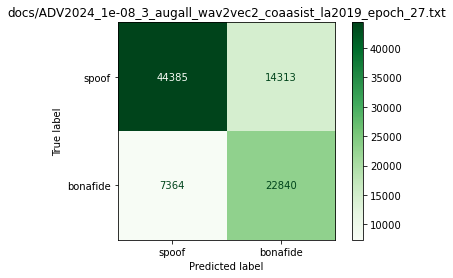

In [13]:
pred_df = pd.read_csv("../../Supcon-voco/docs/ADV2024_5_6_augall_wav2vec2_vib_gelu_supcon_acmccs_large_corpus_nov27_avg.txt", sep=" ", header=None)
pred_df.columns = ["utt", "spoof","score"]

# remove if the utt contain "maibui"
# pred_df = pred_df[~pred_df['utt'].str.contains("maibui")]
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(adv2024, pred_df, on='utt')
# print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')

print("Misclassification rate")
filter = 'alg'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
# print("False negative")
# for group in groups:
#     num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
#     num_total = res_df[res_df[filter]==group].shape[0]
#     print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("docs/ADV2024_1e-08_3_augall_wav2vec2_coaasist_la2019_epoch_27.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

EER: 6.3846%, threshold: -0.0279
Misclassification rate
- - 369 - 0.8158%
rawnet2 - 769 - 6.5313%
aasistssl - 1303 - 34.0565%


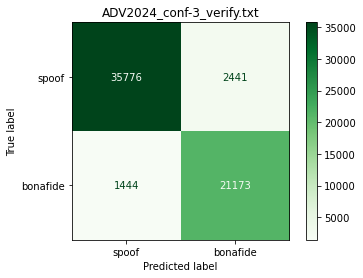

In [18]:

pred_df = pd.read_csv("/datab/phucdt/SCL-Deepfake-audio-detection_bk/docs/ADV2024_conf-3_verify.txt", sep=" ", header=None)
pred_df.columns = ["utt", "spoof","score"]

# remove if the utt contain "maibui"
# pred_df = pred_df[~pred_df['utt'].str.contains("maibui")]
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(adv2024, pred_df, on='utt')
# print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')

print("Misclassification rate")
filter = 'sur_model'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
# print("False negative")
# for group in groups:
#     num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
#     num_total = res_df[res_df[filter]==group].shape[0]
#     print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("ADV2024_conf-3_verify.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

EER: 5.5987%, threshold: -0.7366
Misclassification rate
clean - 487 - 1.0766%
MIFGSM - 151 - 3.9302%
PGD - 1375 - 21.4777%
IFGSM - 174 - 4.4961%
FGSM - 152 - 3.9989%
DIFGSM - 195 - 4.1472%


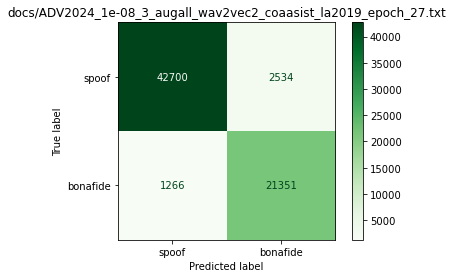

In [13]:
pred_df = pd.read_csv("../../Supcon-voco/docs/ADV2024_1e-08_3_augall_wav2vec2_coaasist_la2019_epoch_27.txt", sep=" ", header=None)
pred_df.columns = ["utt", "spoof","score"]

# remove if the utt contain "maibui"
# pred_df = pred_df[~pred_df['utt'].str.contains("maibui")]
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(adv2024, pred_df, on='utt')
# print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')

print("Misclassification rate")
filter = 'alg'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
# print("False negative")
# for group in groups:
#     num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
#     num_total = res_df[res_df[filter]==group].shape[0]
#     print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("docs/ADV2024_1e-08_3_augall_wav2vec2_coaasist_la2019_epoch_27.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

EER: 5.0360%, threshold: -0.2588
Misclassification rate
clean - 1022 - 1.1130%
MIFGSM - 175 - 2.2393%
PGD - 2517 - 31.3880%
IFGSM - 235 - 2.9898%
FGSM - 183 - 2.3729%
DIFGSM - 242 - 2.5388%


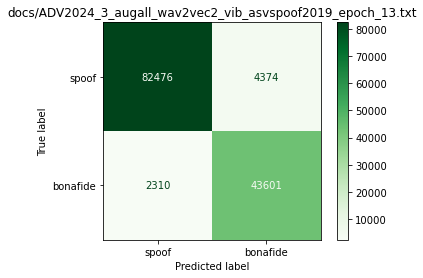

In [14]:
# ADV2024_3_augall_wav2vec2_vib_asvspoof2019_epoch_13.txt
pred_df = pd.read_csv("../../Supcon-voco/docs/ADV2024_3_augall_wav2vec2_vib_asvspoof2019_epoch_13.txt", sep=" ", header=None)
pred_df.columns = ["utt", "spoof","score"]

# remove if the utt contain "maibui"
# pred_df = pred_df[~pred_df['utt'].str.contains("maibui")]
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(adv2024, pred_df, on='utt')
# print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')

print("Misclassification rate")
filter = 'alg'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
# print("False negative")
# for group in groups:
#     num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
#     num_total = res_df[res_df[filter]==group].shape[0]
#     print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("docs/ADV2024_3_augall_wav2vec2_vib_asvspoof2019_epoch_13.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

EER: 55.4543%, threshold: -0.3796
Misclassification rate
clean - 11011 - 24.3423%
MIFGSM - 2009 - 74.1328%
PGD - 478 - 33.8287%
IFGSM - 2146 - 73.3174%
FGSM - 2449 - 64.4304%
DIFGSM - 2017 - 72.1904%


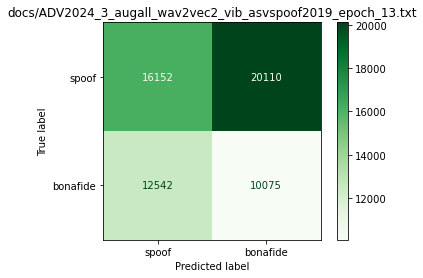

In [15]:
# docs/ADV2024_5_augall_wav2vec2_linear_supcon_feb07_from_nov22_r__29_36_epoch_46.txt
pred_df = pd.read_csv("/dataa/phucdt/vocodetect/Supcon-voco/docs/ADV2024_MIFGSM_RM_adjustCEW_numadv2580_algo3_epoch_19.txt", sep=" ", header=None)
pred_df.columns = ["utt", "spoof","score"]

# remove if the utt contain "maibui"
# pred_df = pred_df[~pred_df['utt'].str.contains("maibui")]
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(adv2024, pred_df, on='utt')
# print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')

print("Misclassification rate")
filter = 'alg'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
# print("False negative")
# for group in groups:
#     num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
#     num_total = res_df[res_df[filter]==group].shape[0]
#     print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("docs/ADV2024_3_augall_wav2vec2_vib_asvspoof2019_epoch_13.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

EER: 51.7841%, threshold: -4.8795
Misclassification rate
clean - 815 - 1.8017%
MIFGSM - 3839 - 99.9219%
PGD - 6402 - 100.0000%
IFGSM - 3867 - 99.9225%
FGSM - 3800 - 99.9737%
DIFGSM - 4701 - 99.9787%


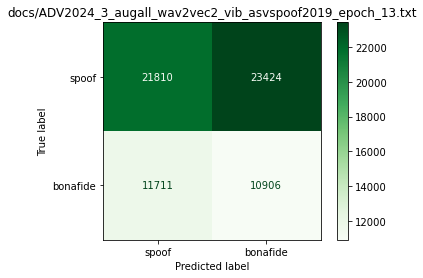

In [6]:
# ADV2024_vib_gelu_large_corpus_from_asvspoof5_20_epoch_11.txt
pred_df = pd.read_csv("../../Supcon-voco/docs/ADV2024_vib_gelu_large_corpus_from_asvspoof5_20_epoch_11.txt", sep=" ", header=None)
pred_df.columns = ["utt", "spoof","score"]

# remove if the utt contain "maibui"
# pred_df = pred_df[~pred_df['utt'].str.contains("maibui")]
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(adv2024, pred_df, on='utt')
# print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')

print("Misclassification rate")
filter = 'alg'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
# print("False negative")
# for group in groups:
#     num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
#     num_total = res_df[res_df[filter]==group].shape[0]
#     print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("docs/ADV2024_3_augall_wav2vec2_vib_asvspoof2019_epoch_13.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

EER: 55.5152%, threshold: -0.3795
Misclassification rate
clean - 11004 - 24.3268%
MIFGSM - 1962 - 72.3985%
PGD - 1841 - 54.6615%
IFGSM - 2093 - 71.5067%
FGSM - 2345 - 61.6943%
DIFGSM - 1974 - 70.6514%


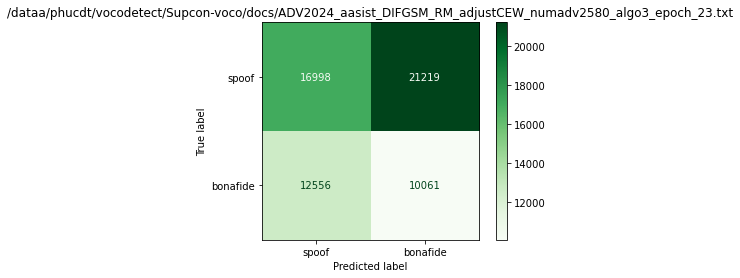

In [ ]:
# /dataa/phucdt/vocodetect/Supcon-voco/docs/ADV2024_aasist_DIFGSM_RM_adjustCEW_numadv2580_algo3_epoch_23.txt
pred_df = pd.read_csv("/dataa/phucdt/vocodetect/Supcon-voco/docs/ADV2024_aasist_DIFGSM_RM_adjustCEW_numadv2580_algo3_epoch_23.txt", sep=" ", header=None)
pred_df.columns = ["utt", "spoof","score"]

# remove if the utt contain "maibui"
# pred_df = pred_df[~pred_df['utt'].str.contains("maibui")]
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(adv2024, pred_df, on='utt')
# print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')

print("Misclassification rate")
filter = 'alg'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
# print("False negative")
# for group in groups:
#     num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
#     num_total = res_df[res_df[filter]==group].shape[0]
#     print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("/dataa/phucdt/vocodetect/Supcon-voco/docs/ADV2024_aasist_DIFGSM_RM_adjustCEW_numadv2580_algo3_epoch_23.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

EER: 55.5345%, threshold: -0.3795
Misclassification rate
clean - 10998 - 24.3136%
MIFGSM - 1966 - 72.5461%
PGD - 1846 - 54.8100%
IFGSM - 2094 - 71.5408%
FGSM - 2347 - 61.7469%
DIFGSM - 1976 - 70.7230%


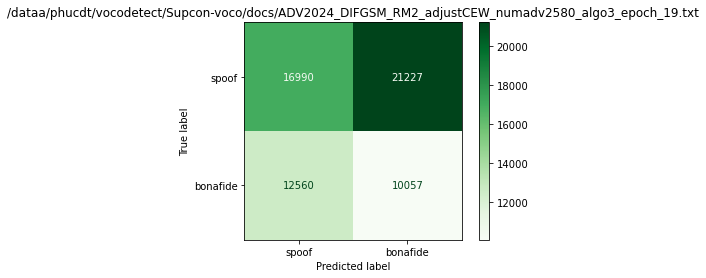

In [19]:
# /dataa/phucdt/vocodetect/Supcon-voco/docs/ADV2024_aasist_DIFGSM_RM_adjustCEW_numadv2580_algo3_epoch_23.txt
pred_df = pd.read_csv("/dataa/phucdt/vocodetect/Supcon-voco/docs/ADV2024_DIFGSM_RM2_adjustCEW_numadv2580_algo3_epoch_19.txt", sep=" ", header=None)
pred_df.columns = ["utt", "spoof","score"]

# remove if the utt contain "maibui"
# pred_df = pred_df[~pred_df['utt'].str.contains("maibui")]
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(adv2024, pred_df, on='utt')
# print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')

print("Misclassification rate")
filter = 'alg'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
# print("False negative")
# for group in groups:
#     num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
#     num_total = res_df[res_df[filter]==group].shape[0]
#     print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("/dataa/phucdt/vocodetect/Supcon-voco/docs/ADV2024_DIFGSM_RM2_adjustCEW_numadv2580_algo3_epoch_19.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()